In [106]:
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
febMar20 = pd.read_csv('Simmer_FebMar20.csv')

/Users/pranavkrishnan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,10,11,12,15,16,17,28,34,41,46,47,52,53,54,58,63,66,67,72,73,74,75,76,77,78,79,80,81,82,83,87,88,89,94,95,96,97,98,99,100,102,108,109,112,113,115,116,117,118,119,121,124,125,126,127,131,132,133,134,135,136,138) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
febMar20.head()

,name,distinct_id,time,sampling_factor,dataset,properties.$ae_session_length,properties.$app_build_number,properties.$app_release,properties.$app_version,properties.$app_version_string,...,properties.distance,properties.ratingCount,properties.Name,properties.CollectionName,properties.IsFoursquareRestaurant,properties.Restaurant,properties.searchQuery,properties.Rated,properties.restaurantComment,properties.ListName
0,$ae_session,fac4dd756360cc15,1582560733000,1,$mixpanel,20.3,101091,101091,1.4.7,1.4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AppOpen,fac4dd756360cc15,1582560712000,1,$mixpanel,NaN,101091,101091,1.4.7,1.4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,$ae_session,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524264000,1,$mixpanel,12.8,2.5.0,2.5.0,2.5.0,2.5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,$ae_session,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524376000,1,$mixpanel,106.3,2.5.0,2.5.0,2.5.0,2.5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AppOpen,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524243000,1,$mixpanel,NaN,2.5.0,2.5.0,2.5.0,2.5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
augSep19 = pd.read_csv('Simmer_AugSep19.csv')

/Users/pranavkrishnan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (32,33,34,35,36,37,38,40,41,44,45,54,81,83,84,85,86,87,94,95,96,97,98,99,100,101,102,103,104,110,114,115,116,118,119,120,121,122,123,124,127,131,133,134,135,140,144,148,152,156,160,164,168,170,171,172,173,174,175,176,177,180,184,188,192,196,200,204,208,212,216,220,224,228,232,236,240,244,248,252,256,258) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
augSep19.head()

,name,distinct_id,time,sampling_factor,dataset,properties.$ae_updated_version,properties.$app_build_number,properties.$app_release,properties.$app_version,properties.$app_version_string,...,properties.initialCategoriesSelected.12.Selected,properties.initialCategoriesSelected.13.Id,properties.initialCategoriesSelected.13.MenuId,properties.initialCategoriesSelected.13.Name,properties.initialCategoriesSelected.13.Selected,properties.initialCategoriesSelected.14.Id,properties.initialCategoriesSelected.14.MenuId,properties.initialCategoriesSelected.14.Name,properties.initialCategoriesSelected.14.Selected,properties.searchQuery
0,$ae_updated,4A47A27E-992F-40D8-8A7E-08CA601D441A,1565013412000,1,$mixpanel,1.9.1,1.9.1,1.9.1,1.9.1,1.9.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AppOpen,4A47A27E-992F-40D8-8A7E-08CA601D441A,1565013413000,1,$mixpanel,NaN,1.9.1,1.9.1,1.9.1,1.9.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AppOpen,866F0631-15CB-40CD-8E0A-04753AFFB01A,1565145944000,1,$mixpanel,NaN,1.9.2,1.9.2,1.9.2,1.9.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Visit Signup/Login Page,866F0631-15CB-40CD-8E0A-04753AFFB01A,1565145948000,1,$mixpanel,NaN,1.9.2,1.9.2,1.9.2,1.9.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,$ae_first_open,12C9B87A-53B0-4283-9083-40AE9F8AB95A,1565522925000,1,$mixpanel,NaN,1.9.3,1.9.3,1.9.3,1.9.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
decJan19 = pd.read_csv('Simmer_DecJan19.csv')

/Users/pranavkrishnan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,13,20,26,33,34,36,37,38,39,40,42,43,44,45,47,64,70,72,73,75,76,77,79,80,81,82,89,90,91,92,93,97,98,99,101,105,106,107,109,110,111,112,114,117,118,119,120,124,128,132,136,140,144,148,152,156,160,164,166,167,168,173,177,181,185,189,193,195,196,197,199,202,205,209,213,217,221,225,229,233,235,237,239,240) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
decJan19.head()

,name,distinct_id,time,sampling_factor,dataset,properties.$ae_session_length,properties.$app_build_number,properties.$app_release,properties.$app_version,properties.$app_version_string,...,properties.initialCategoriesSelected.11.Id,properties.initialCategoriesSelected.11.MenuId,properties.initialCategoriesSelected.11.Name,properties.initialCategoriesSelected.11.Selected,properties.$browser,properties.$browser_version,properties.$device,properties.campaign_id,properties.existingDate,properties.newDate
0,$ae_session,29152811-7C4C-43AE-B829-D467F9073B0F,1580447805000,1,$mixpanel,59,2.3.3,2.3.3,2.3.3,2.3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AppOpen,29152811-7C4C-43AE-B829-D467F9073B0F,1580447746000,1,$mixpanel,NaN,2.3.3,2.3.3,2.3.3,2.3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Feed - Scroll Down,29152811-7C4C-43AE-B829-D467F9073B0F,1580447753000,1,$mixpanel,NaN,2.3.3,2.3.3,2.3.3,2.3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Feed - Scroll Down,29152811-7C4C-43AE-B829-D467F9073B0F,1580447772000,1,$mixpanel,NaN,2.3.3,2.3.3,2.3.3,2.3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Home - Explore Nearby,29152811-7C4C-43AE-B829-D467F9073B0F,1580447750000,1,$mixpanel,NaN,2.3.3,2.3.3,2.3.3,2.3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
octNov19 = pd.read_csv('Simmer_OctNov19.csv')

/Users/pranavkrishnan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,35,36,37,38,42,43,44,45,78,80,81,82,83,84,85,87,88,89,90,91,92,93,94,95,104,111,112,113,115,116,123,124,125,126,127,128,129,131,132,133,134,135,136,139,140,141,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200,204,208,212,216,220,224,228,232,236,240,244,248,252,256,260,262,263,264,266,268,270,271,273,274,275) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [71]:
octNov19.head()

,name,distinct_id,time,sampling_factor,dataset,properties.$ae_session_length,properties.$app_build_number,properties.$app_release,properties.$app_version,properties.$app_version_string,...,properties.ItemName,properties.CategoryId,properties.CategoryName,properties.ItemId,properties.existingDate,properties.newDate,properties.restaurantDescription,properties.Follow,properties.userMessage,properties.Page
0,$ae_session,D007B42B-0927-46EE-A333-AF997781510F,1575129207000,1,$mixpanel,10,2.3.3,2.3.3,2.3.3,2.3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,$ae_session,D007B42B-0927-46EE-A333-AF997781510F,1575129265000,1,$mixpanel,22.6,2.3.3,2.3.3,2.3.3,2.3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,$ae_session,D007B42B-0927-46EE-A333-AF997781510F,1575129278000,1,$mixpanel,10.7,2.3.3,2.3.3,2.3.3,2.3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,$ae_session,D007B42B-0927-46EE-A333-AF997781510F,1575129353000,1,$mixpanel,63.7,2.3.3,2.3.3,2.3.3,2.3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,$ae_session,D007B42B-0927-46EE-A333-AF997781510F,1575129953000,1,$mixpanel,596.2,2.3.3,2.3.3,2.3.3,2.3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
nullCountsAugSep = pd.DataFrame({'Column Name': augSep19.columns, 'Null Count' : [augSep19[column].isnull().sum() for column in augSep19.columns]})


In [58]:
nullCountsDecJan = pd.DataFrame({'Column Name': decJan19.columns, 'Null Count' : [decJan19[column].isnull().sum() for column in decJan19.columns]})


In [65]:
nullCountsFebMar = pd.DataFrame({'Column Name': febMar20.columns, 'Null Count' : [febMar20[column].isnull().sum() for column in febMar20.columns]})


In [73]:
nullCountsOctNov = pd.DataFrame({'Column Name': octNov19.columns, 'Null Count': [octNov19[column].isnull().sum() for column in octNov19.columns]})


In [82]:
nullCountsAugSep[nullCountsAugSep['Null Count'] < 0.3 * len(augSep19)]


,Column Name,Null Count
0,name,0
1,distinct_id,0
2,time,0
3,sampling_factor,0
4,dataset,0
6,properties.$app_build_number,0
7,properties.$app_release,0
8,properties.$app_version,0
9,properties.$app_version_string,0
10,properties.$carrier,1181


In [61]:
nullCountsDecJan[nullCountsDecJan['Null Count'] < .3 * len(decJan19)]

,Column Name,Null Count
0,name,0
1,distinct_id,0
2,time,0
3,sampling_factor,0
4,dataset,0
6,properties.$app_build_number,1
7,properties.$app_release,1
8,properties.$app_version,1
9,properties.$app_version_string,1
10,properties.$carrier,551


In [80]:
nullCountsFebMar[nullCountsFebMar['Null Count'] < .2 * len(febMar20)]

,Column Name,Null Count
0,name,0
1,distinct_id,0
2,time,0
3,sampling_factor,0
4,dataset,0
6,properties.$app_build_number,0
7,properties.$app_release,0
8,properties.$app_version,0
9,properties.$app_version_string,0
13,properties.$carrier,414


In [77]:
nullCountsOctNov[nullCountsOctNov['Null Count'] < .3 * len(octNov19)]

,Column Name,Null Count
0,name,0
1,distinct_id,0
2,time,0
3,sampling_factor,0
4,dataset,0
6,properties.$app_build_number,1050
7,properties.$app_release,1050
8,properties.$app_version,1050
9,properties.$app_version_string,1050
10,properties.$carrier,1711


In [95]:
columns_values = {}
df_list = [febMar20, decJan19, octNov19, augSep19]
selected_columns = list(nullCountsOctNov[nullCountsOctNov['Null Count'] < .3 * len(octNov19)]['Column Name'])
for column in selected_columns:
    for df in df_list:
        if column in columns_values:
            columns_values[column] += list(df[column])
        else:
            columns_values[column] = []
            columns_values[column] += list(df[column])

past7Months = pd.DataFrame(columns_values)

In [96]:
past7Months

,name,distinct_id,time,sampling_factor,dataset,properties.$app_build_number,properties.$app_release,properties.$app_version,properties.$app_version_string,properties.$carrier,...,properties.$region,properties.$screen_height,properties.$screen_width,properties.$user_id,properties.$wifi,properties.UUId,properties.mp_country_code,properties.mp_device_model,properties.mp_lib,properties.mp_processing_time_ms
0,$ae_session,fac4dd756360cc15,1582560733000,1,$mixpanel,101091,101091,1.4.7,1.4.7,Google Fi,...,California,2094.0,1080.0,NaN,True,fac4dd756360cc15,US,NaN,android,1582589534045
1,AppOpen,fac4dd756360cc15,1582560712000,1,$mixpanel,101091,101091,1.4.7,1.4.7,Google Fi,...,California,2094.0,1080.0,NaN,True,fac4dd756360cc15,US,NaN,android,1582589533972
2,$ae_session,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524264000,1,$mixpanel,2.5.0,2.5.0,2.5.0,2.5.0,T-Mobile,...,Maryland,812.0,375.0,B16482B3-A3CD-4A27-B579-34F79CC47396,False,B16482B3-A3CD-4A27-B579-34F79CC47396,US,"iPhone12,3",iphone,1583553129756
3,$ae_session,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524376000,1,$mixpanel,2.5.0,2.5.0,2.5.0,2.5.0,T-Mobile,...,Maryland,812.0,375.0,B16482B3-A3CD-4A27-B579-34F79CC47396,False,B16482B3-A3CD-4A27-B579-34F79CC47396,US,"iPhone12,3",iphone,1583553176144
4,AppOpen,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524243000,1,$mixpanel,2.5.0,2.5.0,2.5.0,2.5.0,T-Mobile,...,Maryland,812.0,375.0,B16482B3-A3CD-4A27-B579-34F79CC47396,False,B16482B3-A3CD-4A27-B579-34F79CC47396,US,"iPhone12,3",iphone,1583553129756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190366,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787552000,1,$mixpanel,2.1.6,2.1.6,2.1.6,2.1.6,AT&T,...,California,812.0,375.0,A8E48126-0505-4560-AF2E-58720466A847,True,A8E48126-0505-4560-AF2E-58720466A847,US,"iPhone12,3",iphone,1569812761064
190367,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787554000,1,$mixpanel,2.1.6,2.1.6,2.1.6,2.1.6,AT&T,...,California,812.0,375.0,A8E48126-0505-4560-AF2E-58720466A847,True,A8E48126-0505-4560-AF2E-58720466A847,US,"iPhone12,3",iphone,1569812761031
190368,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787555000,1,$mixpanel,2.1.6,2.1.6,2.1.6,2.1.6,AT&T,...,California,812.0,375.0,A8E48126-0505-4560-AF2E-58720466A847,True,A8E48126-0505-4560-AF2E-58720466A847,US,"iPhone12,3",iphone,1569812761031
190369,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787559000,1,$mixpanel,2.1.6,2.1.6,2.1.6,2.1.6,AT&T,...,California,812.0,375.0,A8E48126-0505-4560-AF2E-58720466A847,True,A8E48126-0505-4560-AF2E-58720466A847,US,"iPhone12,3",iphone,1569812761030


## 

In [105]:
past7Months['properties.$region'].value_counts()

California                   41886
Gujarat                      25055
Illinois                     17403
New York                     14434
District of Columbia         12427
                             ...  
Bavaria                          1
Muharraq                         1
Muhafazat as Sulaymaniyah        1
Haringey                         1
Colombo District                 1
Name: properties.$region, Length: 253, dtype: int64

<BarContainer object of 4 artists>

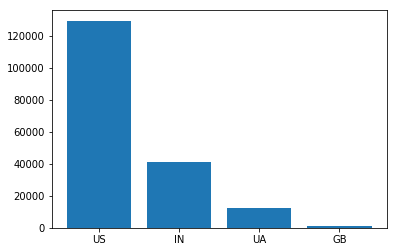

In [118]:
series = past7Months['properties.mp_country_code'].value_counts()
region = series[series > 1000] #More than 1000 records of country_code
plt.bar(region.index, region.values)

In [125]:
list(past7Months['distinct_id'].value_counts().index)

['nb@gmail.com_93',
 '4E1A70A0-C2DB-46EB-A9C8-B4F0B0815771',
 'richard.z.wu@gmail.com_136',
 'vaibhavverma9@uchicago.edu_56',
 'ab.codebase@gmail.com_52',
 'mai.nabar@gmail.com_104',
 '7DBBA8FA-9050-4E9E-A779-F12643B7FBF5',
 'hr@gmail.com_87',
 'd2baa8a36ca0137d',
 'Dzavala@uchicago.edu_118',
 'A5E08D96-5206-4FB4-AF48-3ABE63689BB4',
 '7466E480-A994-4CFC-BAFD-C9B96841A8A3',
 'eemilyshenn@gmail.com_227',
 '3408a5eb77f5751e',
 'D7ABC103-E971-41DB-BFCD-ACDF8F95C0DE',
 'scao21@uchicago.edu_116',
 'E1A6A21B-DA7E-4D8B-AB87-9ECA71047891',
 '3746E57C-9D7E-42BC-81D7-16B0269E70ED',
 'cd3bff659f73b447',
 'DD19DD90-BB46-41AD-AC1C-8D163196902D',
 'BD5966E0-75A6-4640-9B61-388008E081AD',
 'FC9EF9C7-23BA-4B05-93EC-CC18F95EDEC1',
 '948118ED-04FA-4F48-ACCA-452AD6736C93',
 'jeencall@yahoo.com_248',
 '641A75B2-A246-4F8E-B81A-EFA8B364F0C5',
 'C978938A-F240-4FF6-B7B5-1943A5041774',
 '582FE9F6-5A27-4FC0-8F7D-CCEA4AE76AF8',
 'spatel@gmail.com_53',
 'B2DD3857-E455-4A0C-BA52-75BD79228B0B',
 '1C2F8F94-4183-42D3-B

In [130]:
series = past7Months['distinct_id'].value_counts()
series[series > 30]

nb@gmail.com_93                         18347
4E1A70A0-C2DB-46EB-A9C8-B4F0B0815771    12049
richard.z.wu@gmail.com_136               6437
vaibhavverma9@uchicago.edu_56            5482
ab.codebase@gmail.com_52                 3474
                                        ...  
A26327E6-A444-4979-B5E5-7553ECAC5ECA       31
2381BB3D-2198-432D-824F-A1C9F6FA1DFF       31
93E7D4B7-54AD-4875-95F2-66E5C4709FAE       31
CB8C65DE-038B-479C-960B-87772D423FF9       31
47C63431-1FE3-40DC-88D8-5B44DB7069F2       31
Name: distinct_id, Length: 971, dtype: int64

In [132]:
peopleDF = pd.read_csv('People_Sample.csv')

In [133]:
peopleDF

,distinct_id,last_seen,properties.$ae_total_app_session_length,properties.$android_manufacturer,properties.$ios_app_release,properties.UUId,properties.Name,properties.$android_brand,properties.$first_name,properties.$android_os_version,...,properties.$mp_message_sends.c3477163.c,properties.$mp_message_sends.c3477163.t,properties.$mp_message_sends.c3448143.c,properties.$mp_message_sends.c3448143.t,properties.$mp_message_sends.c3477188.c,properties.$mp_message_sends.c3477188.t,properties.$mp_message_sends.c3426120.c,properties.$mp_message_sends.c3426120.t,properties.$mp_message_sends.c3520460.c,properties.$mp_message_sends.c3520460.t
0,hr@gmail.com_87,1583215712863,345721,LENOVO,2.5.0,C08A8A93-E860-44E3-AF59-050703FB05E3,Harshil Raval,Lenovo,Harshil,5.1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E2D9AB63-1718-4D1E-936F-10BE1D889989,1567912547284,4412,NaN,2.0.5,E2D9AB63-1718-4D1E-936F-10BE1D889989,Theodore Wu,NaN,Theodore,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,vaibhavverma9@gmail.com_56,1555341505597,71430,NaN,1.3.7,0F26547E-C6B8-41EC-B4D9-C241E4A5F8E7,Vaibhav Verma,NaN,Vaibhav,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0C954A3F-0AB6-4D12-B4E9-D916C95B0C6E,1573324386541,12836,NaN,2.1.6,6057C4E1-F67B-49A5-AAF4-BF70F9F340FE,Tiffany Qi,NaN,Tiffany,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,addidas23@gmail.com_139,1584544161949,2066,NaN,2.5.4,CF15C7DE-F8DF-42BD-9E48-BB8787051CED,Nathan Nangia,NaN,Nathan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,52774481-EECA-4703-8F31-F634B24773BE,1582419573966,161801,NaN,2.4.7,52260961-5F4B-4915-B149-577F2E548C63,Reyna Huang,NaN,Reyna,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,F4B6EE31-E835-4C5D-8387-456DFF4E9A3D,1584808995375,8308,NaN,2.5.0,F4B6EE31-E835-4C5D-8387-456DFF4E9A3D,Christine Duke,NaN,Christine,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,04ADA4C3-9212-49DA-B600-67A8403D69C3,1579398082980,2283,NaN,2.3.3,04ADA4C3-9212-49DA-B600-67A8403D69C3,Alexandria Ma,NaN,Alexandria,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,619EECB8-EA49-493B-9048-4EAB912BF98E,1576121749723,4227,NaN,2.3.3,619EECB8-EA49-493B-9048-4EAB912BF98E,Lucy Li,NaN,Lucy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
[name for name in peopleDF['distinct_id'] if '@' in name]

['hr@gmail.com_87',
 'vaibhavverma9@gmail.com_56',
 'addidas23@gmail.com_139',
 'harshil1088@gmail.com_51',
 'ca8jessica17@gmail.com_277',
 'a.road100@gmail.com_199',
 'meggiesu8@gmail.com_253',
 'jamesyoungny@gmail.com_152',
 'andreagrant98@gmail.com_260',
 'nb@gmail.com_93',
 'zosegal@gmail.com_198',
 'richard.z.wu@gmail.com_136',
 'rebeccaqian@uchicago.edu_271',
 'joefennessey23@yahoo.com_145',
 'vaibhavverma9@uchicago.edu_126',
 'eemilyshenn@gmail.com_227',
 'spatel@gmail.com_53',
 'newberr1@gmail.com_310',
 'robert@gmail.com_2468',
 'hgiovannelli@uchicago.edu_308',
 'kathaypacific@gmail.com_68',
 'scao21@uchicago.edu_116',
 'psteelers10@gmail.com_238',
 'surelyfoodhere@gmail.com_318',
 'nailesh2010@gmail.com_62',
 'Dzavala@uchicago.edu_118',
 'jeencall@yahoo.com_248',
 'mai.nabar@gmail.com_104',
 'vaibhavverma9@uchicago.edu_56',
 'cj96n@hotmail.com_181',
 'kk.kathy@hotmail.com_72',
 'girlsrule728@gmail.com_180',
 'ab.codebase@gmail.com_52',
 'andrewjabara@gmail.com_311',
 'rickeat